In [ ]:
import torch
from ptflops import get_model_complexity_info
import pandas as pd
import os
import torch
import numpy as np
from models.team_net_ic import TEAM_Net

num_segments = 8
num_classes = 101

class TeamNetWrapper(torch.nn.Module):
    def __init__(self, num_segments, num_classes=101, exit_idx=4):
        super(TeamNetWrapper, self).__init__()
        self.model = TEAM_Net(
            num_class=num_classes, 
            num_segments=num_segments,
            base_model='resnet50')

        self.exit_idx = exit_idx
    
    def forward(self, inputs):
        input_i, input_mv, input_r = inputs[:, :, 0:3], inputs[:, :, 3:5], inputs[:, :, 5:]
        if self.exit_idx == 1:
            return self.model.exit1(input_i, input_mv, input_r)
        elif self.exit_idx == 2:
            return self.model.exit2(input_i, input_mv, input_r)
        elif self.exit_idx == 3:
            return self.model.exit3(input_i, input_mv, input_r)

        output = self.model(input_i, input_mv, input_r)
        return output    

macs_exits = {}
for num_classes, dataset in [(101, 'ucf101'), (51, 'hmdb51')]:
    for exits in [1,2,3,4]:
        net = TeamNetWrapper(num_segments, num_classes, exits)
        macs, params = get_model_complexity_info(
            net, 
            (num_segments, 8, 224, 224), 
            as_strings=False,
            print_per_layer_stat=False, 
            verbose=False)

        if dataset in macs_exits:
            macs_exits[dataset].append(macs)
        else:
            macs_exits[dataset] = [macs]

def get_mac_for_exit(dataset, exit):
    return macs_exits[dataset][exit-1]

In [2]:
logit_save_path = 'set path'
trade_off_path = 'set path'
ucf_trade_off_path = 'set path'

In [3]:
accs = []
seeds = []
thresholds = []
splits = []
datasets = []
ics = []
macs = []
save_path = logit_save_path
thres = np.linspace(0, 1.1, 13).tolist()
for data_name in ["ucf101", "hmdb51"]:
    for split in ["split1", "split2", "split3"]:
            for seed in [1, 736, 4711]:
                for ic in ['IC2', 'IC3']:
                    for threshold in thres:
                        save_file = f"val_logits_{data_name}_{ic}_seed_{seed}_{split}.pt"
                        val_logits = torch.load(os.path.join(save_path, save_file))
                        out_IC1 = val_logits['ic1']
                        out_IC2 = val_logits['ic2']
                        out_IC3 = val_logits['ic3']
                        out = val_logits['out']
                        target = val_logits['true_labels']

                        prob_1 = torch.nn.functional.softmax(out_IC1, 1)
                        prob_2 = torch.nn.functional.softmax(out_IC2, 1)
                        prob_3 = torch.nn.functional.softmax(out_IC3, 1)
                        prob_4 = torch.nn.functional.softmax(out, 1)

                        idx1 = prob_1.max(1)[0] > threshold
                        idx2 = prob_2.max(1)[0] > threshold
                        idx2 = torch.where(idx2 & ~idx1, idx2, False)
                        idx3 = prob_3.max(1)[0] > threshold
                        idx3 = torch.where(idx3 & ~(idx2 | idx1), idx3, False)
                        idx4 = torch.where(idx1 | idx2 | idx3, 0, 1)

                        correct1 = (prob_1.max(1)[1] == target)[idx1.nonzero().flatten()].sum()
                        correct2 = (prob_2.max(1)[1] == target)[idx2.nonzero().flatten()].sum()
                        correct3 = (prob_3.max(1)[1] == target)[idx3.nonzero().flatten()].sum()
                        correct4 = (prob_4.max(1)[1] == target)[idx4.nonzero().flatten()].sum()

                        total_macs = correct1 * get_mac_for_exit(data_name, 1) + \
                            correct2 * get_mac_for_exit(data_name, 2) + \
                            correct3 * get_mac_for_exit(data_name, 3) + \
                            (idx4.sum()) * get_mac_for_exit(data_name, 4)
                        
                        # print(f"Dataset {data_name}: {threshold}: {correct1}, {correct2}, {correct3}, {correct4}")

                        acc = (correct1 + correct2 + correct3 + correct4) / len(prob_1)
                        accs.append(acc.item())
                        seeds.append(seed)
                        thresholds.append(threshold)
                        splits.append(split)
                        ics.append(ic)
                        datasets.append(data_name)
                        macs.append(total_macs.item() / (1024 ** 3))


In [4]:
df = pd.DataFrame(data={'seed': seeds, 'ic': ics, 'split': splits, 'dataset': datasets, 'threshold': thresholds, 'acc': accs, 'macs': macs})
pd.options.display.float_format = '{:,.4f}'.format
df_summary = df.groupby(['dataset', 'threshold'])[['acc', 'macs']].mean()
df_summary['macs'] = df_summary['macs'] * 3

[68.10457516 68.49673203 60.30501089 65.05446623] [208248.3  235102.47  56340.27 107408.3 ] 66.05633333333333


Text(67.96215533221775, 0.5, 'Accuracy (\\%)')

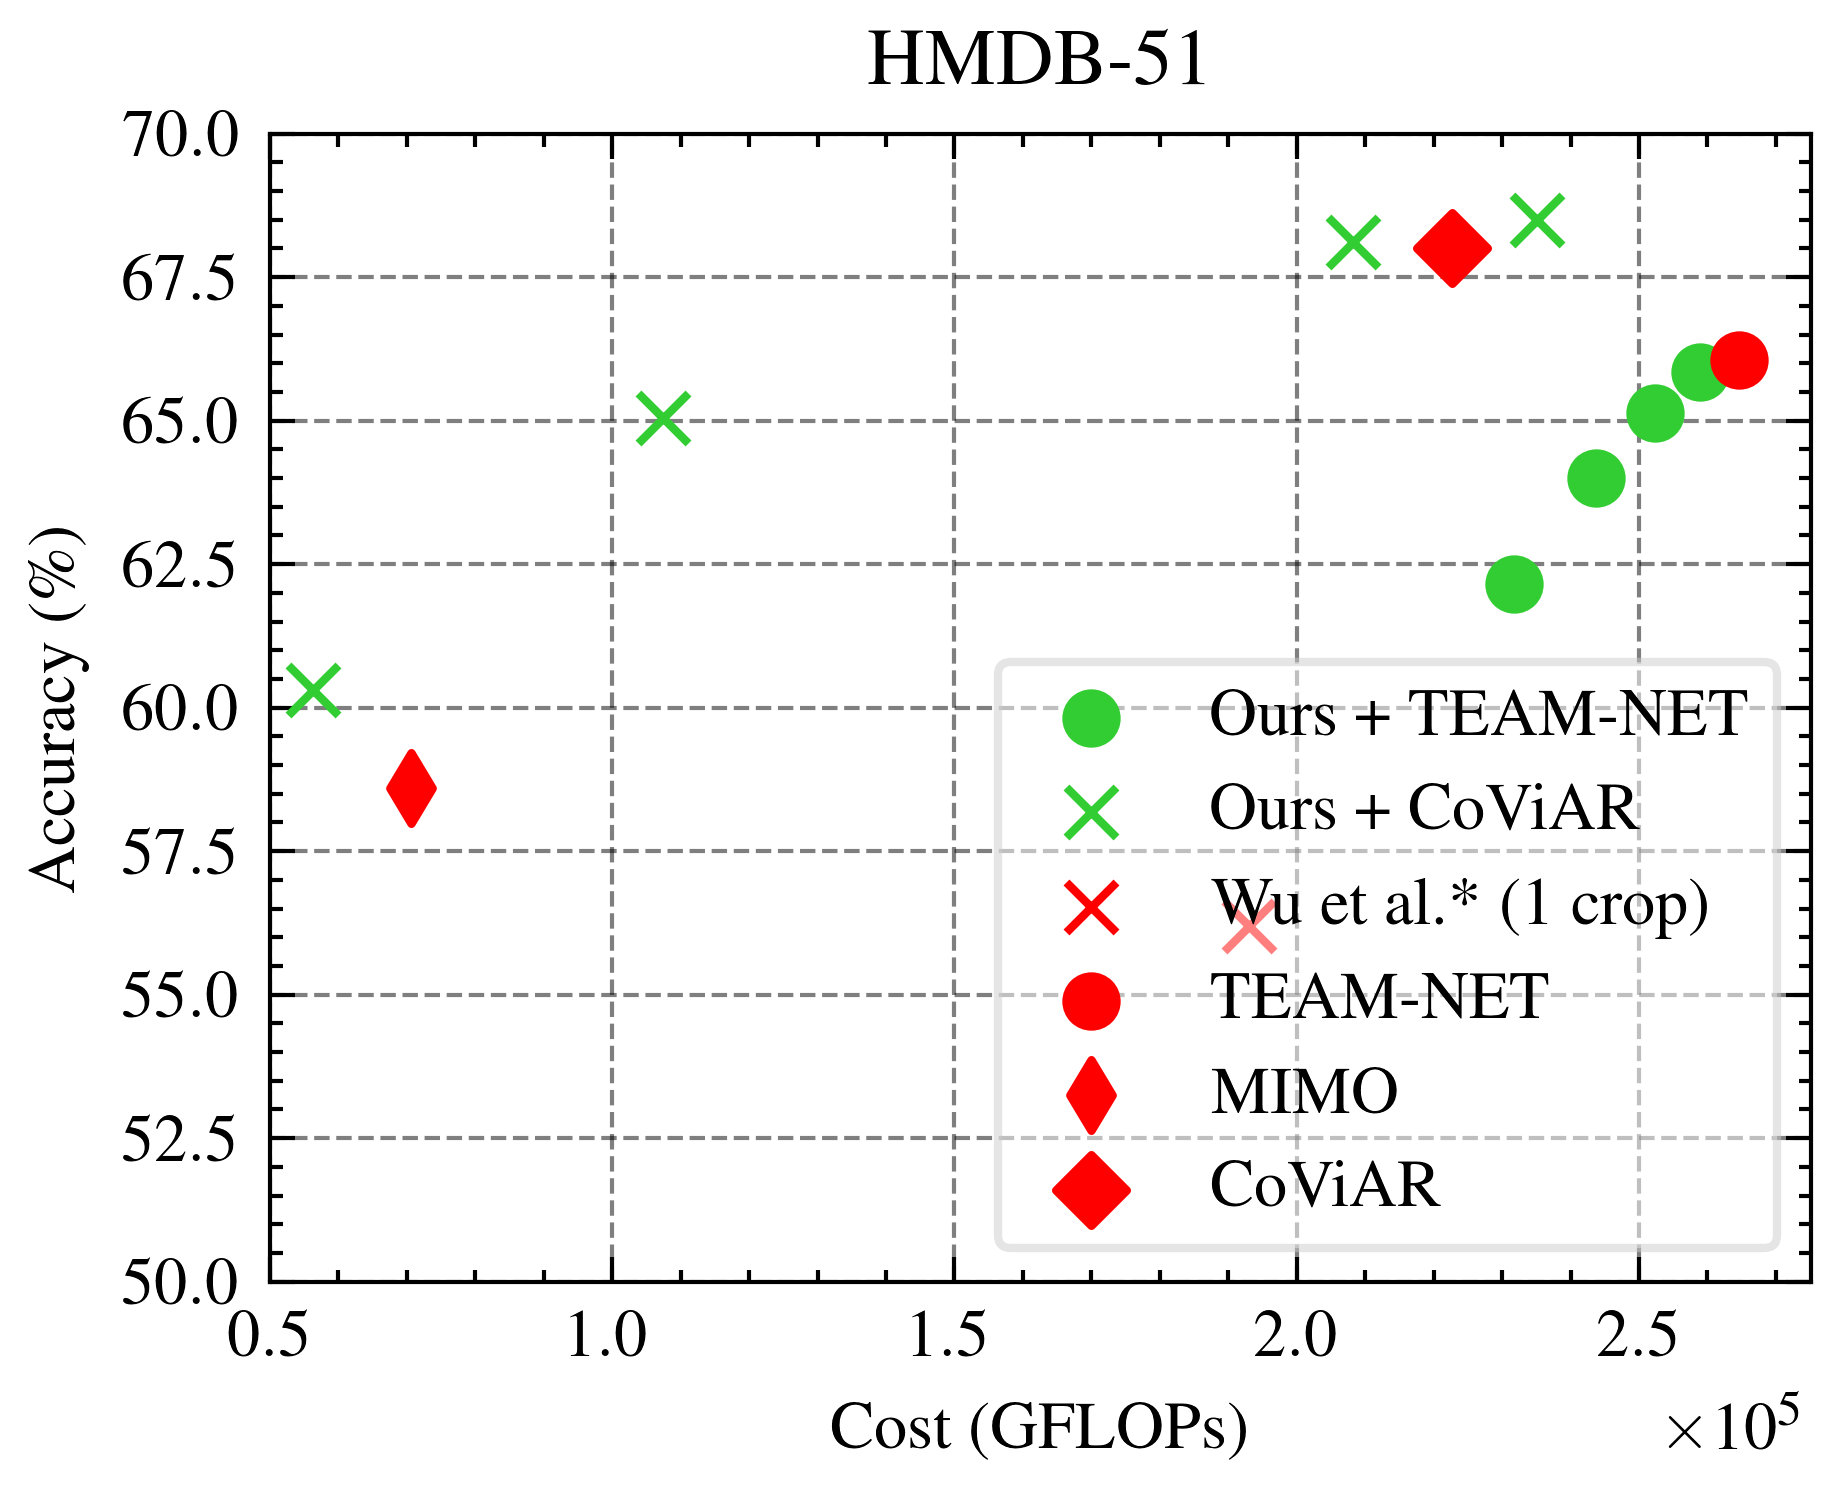

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scienceplots

plt.style.use(['ieee', 'science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
our_acc = None
our_macs = None
for split in [1, 2, 3]:
    if our_acc is None:
        our_acc = np.load(f"{trade_off_path}/list_acc_cost_hmdb51/list_acc_split{split}_wise_trade_off_hmdb51_no_division.npy")
        our_macs = np.load(f"{trade_off_path}/list_acc_cost_hmdb51/list_cost_split{split}_wise_trade_off_hmdb51_no_division.npy")
    else:
        our_acc += np.load(f"{trade_off_path}/list_acc_cost_hmdb51/list_acc_split{split}_wise_trade_off_hmdb51_no_division.npy")
        our_macs += np.load(f"{trade_off_path}/list_acc_cost_hmdb51/list_cost_split{split}_wise_trade_off_hmdb51_no_division.npy")

our_acc = our_acc / 3
fig = plt.figure(figsize=(width, height))
data = df_summary.iloc[:13]

plt.scatter(data['macs'][-6:-2], data['acc'][-6:-2] * 100, c='limegreen', label='Ours + TEAM-NET')
plt.scatter(our_macs, our_acc,c='limegreen', marker='x', label='Ours + CoViAR')
plt.scatter(193065, 56.2, label='Wu et al.* (1 crop)', c='r', marker='x')
plt.scatter(264639, (65.991 + 66.449 + 65.729) / 3, c='r', label='TEAM-NET') # 65.991 + 66.449 + 65.729
plt.scatter(70639, 58.6, label='MIMO', c='r', marker='d')
plt.scatter(222615, 68, label='CoViAR', c='r', marker='D')
plt.title('HMDB-51')

plt.legend(loc='lower right')
print(our_acc, our_macs, (65.991 + 66.449 + 65.729) / 3)

# Create a ScalarFormatter object
formatter = ScalarFormatter(useOffset=True, useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((1,3))

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(formatter)

plt.ylim(72, 95)
plt.xlabel('Cost (GFLOPs)')


plt.legend(fancybox=True, framealpha=0.5)
plt.ylim(50, 70)
plt.xlim(left=50000)
plt.ylabel('Accuracy (\%)')
plt.savefig("./plots/HMDB51_trade_off.png")
plt.ylabel('Accuracy (\%)')

[92.76714633 92.55247103 88.41395799 90.55576568 91.67114289] [508733.81 440649.21 147391.27 179791.22 261876.02] 93.35466666666667


<Figure size 2100x1575 with 0 Axes>

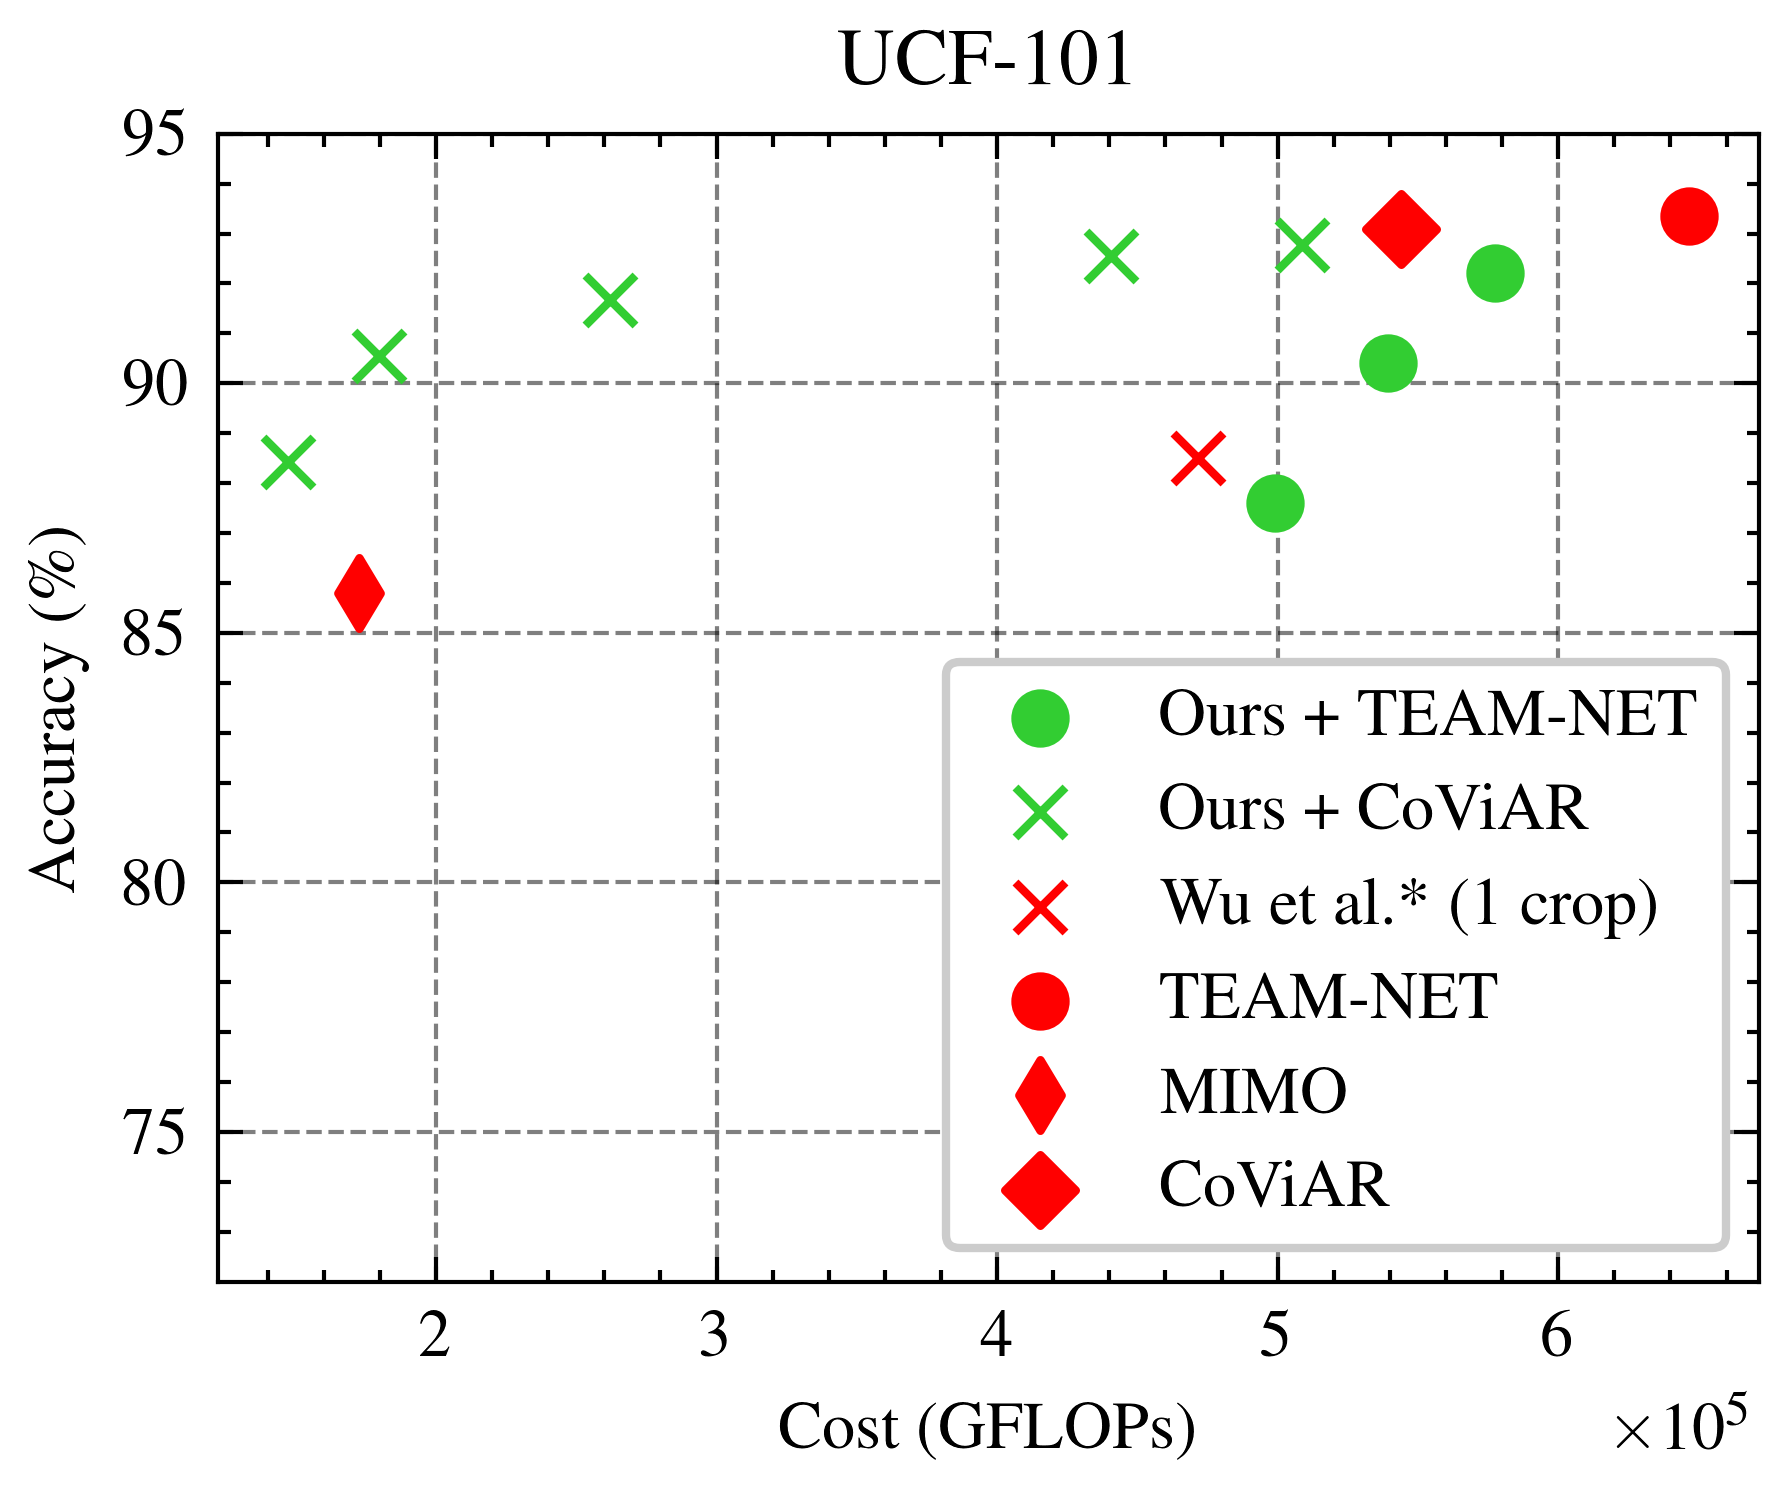

In [6]:


data = df_summary.iloc[13:]
plt.figure()
plt.style.use(['ieee', 'science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
our_acc = None
our_macs = None
for split in [1, 2, 3]:
    if our_acc is None:
        our_acc = np.load(f"{ucf_trade_off_path}/list_acc_split{split}_wise_trade_off_ucf101.npy")
        our_macs = np.load(f"{ucf_trade_off_path}/list_cost_split{split}_wise_trade_off_ucf101.npy")
    else:
        our_acc += np.load(f"{ucf_trade_off_path}/list_acc_split{split}_wise_trade_off_ucf101.npy")
        our_macs += np.load(f"{ucf_trade_off_path}/list_cost_split{split}_wise_trade_off_ucf101.npy")

our_acc = our_acc / 3
fig = plt.figure(figsize=(width, height))

plt.scatter(data['macs'][-5:-2], data['acc'][-5:-2] * 100, c='limegreen', label='Ours + TEAM-NET')
plt.scatter(our_macs, our_acc,c='limegreen', marker='x', label='Ours + CoViAR')
plt.scatter(471706, 88.5, label='Wu et al.* (1 crop)', c='r', marker='x')
plt.scatter(646582, (92.7 + 94.051 + 93.313)/ 3, c='r', label='TEAM-NET') # 92.7 + 94.051 + 93.313
plt.scatter(172587, 85.8, label='MIMO', c='r', marker='d')
plt.scatter(543903, 93.1, label='CoViAR', c='r', marker='D')
print(our_acc, our_macs, (92.7 + 94.051 + 93.313)/ 3)
plt.legend(loc='lower right')
plt.title('UCF-101')

# Create a ScalarFormatter object
formatter = ScalarFormatter(useOffset=True, useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((1,3))

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(formatter)

plt.ylim(72, 95)
plt.xlabel('Cost (GFLOPs)')
plt.ylabel('Accuracy (\%)')
plt.savefig("./plots/UCF101_trade_off.png")